# A Notebook for Plotting Intergenerational Learning

## Imports

In [1]:
# IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import numpy as np
import os

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams.update({'text.color': "black",
                     'axes.labelcolor': "black"})


In [3]:
# nice plot templates
!wget https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine-dawn.mplstyle -P /tmp

--2023-09-30 02:07:48--  https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine-dawn.mplstyle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40905 (40K) [text/plain]
Saving to: ‘/tmp/rose-pine-dawn.mplstyle.23’

rose-pine-dawn.mpls 100%[===================>]  39,95K  --.-KB/s    in 0,05s   

2023-09-30 02:07:49 (771 KB/s) - ‘/tmp/rose-pine-dawn.mplstyle.23’ saved [40905/40905]



## Data Imports

In [14]:
stats_signif = 9
n_bots = 6
max_life_span_dfs = {}
life_spans = [30, 50, 100]
result_path = "../results_intergen/"
figures_path = "../results_intergen/figures/"

In [15]:
def read_csv_file(path, filename):
    full_path = os.path.join(path, filename)
    if os.path.exists(full_path):
        return pd.read_csv(full_path, usecols=lambda col: col not in ['Unnamed: 0'])
    else:
        print(f"File not found: {full_path}")
        return None

In [16]:
max_life_span_dfs = {}
for n_life_span in life_spans:
    max_life_span_dfs[n_life_span] = []  # List for each lifespan
    for n_bot in range(1, n_bots + 1):
        bot_dfs = []  # List for each bot
        path = os.path.join(result_path, f"max_life_span{n_life_span}", f"bot{n_bot}")
        for k in range(1, stats_signif + 1):
            filename = f"trial{k}.csv"
            bot_df = read_csv_file(path, filename)
            if bot_df is not None:
                bot_dfs.append(bot_df)  # Append trial DataFrame to the bot list
        max_life_span_dfs[n_life_span].append(bot_dfs)  # Append the bot list to the lifespan list


In [17]:
print(len(max_life_span_dfs[50][0]))

9


# Dataframes so far:
1. dict with the different life spans; each bot has their own list with 13 trials

In [18]:
PROHIBITIONS = {
  'obs["CUR_CELL_HAS_APPLE"] and obs["NUM_APPLES_AROUND"] < 3 -> !MOVE_ACTION': "Too few apples prohibition",
  'obs["CUR_CELL_HAS_APPLE"] and obs["CUR_CELL_IS_FOREIGN_PROPERTY"] -> !MOVE_ACTION': "Don't steal prohibition",
}
OBLIGATION_CLEANER = {
    'obs["DIRT_FRACTION"] > 0.3 and obs["AGENT_LOOK"] == 1 -> obs["SINCE_AGENT_LAST_CLEANED"] == 0': "Cleaner clean obligation"
}
OBLIGATION_FARMER = {
    'obs["SINCE_AGENT_LAST_PAID"] > 30 and obs["AGENT_LOOK"] == 2 -> obs["SINCE_AGENT_LAST_PAID"] == 0': "Farmer pay obligation",
}
OBLIGATION_FREE = {
    'obs["DIRT_FRACTION"] > 0.45 and obs["AGENT_LOOK"] == 0 -> obs["SINCE_AGENT_LAST_CLEANED"] == 0': "Egalitarian clean obligation",
}

In [19]:
# Combine all rules into one dictionary for easier looping
all_rules = {**PROHIBITIONS, **OBLIGATION_CLEANER, **OBLIGATION_FARMER, **OBLIGATION_FREE}

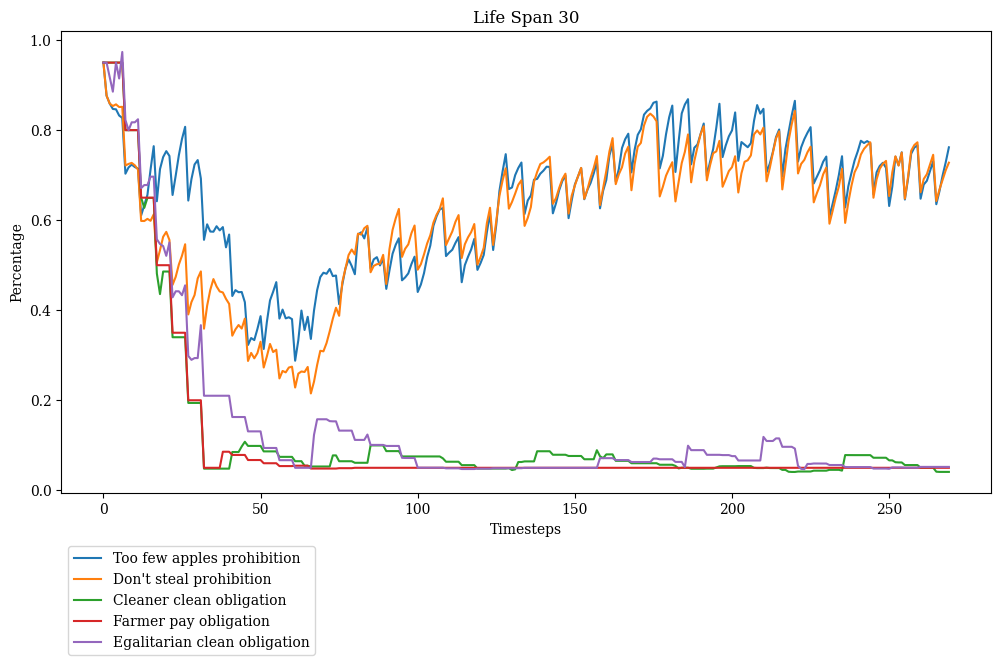

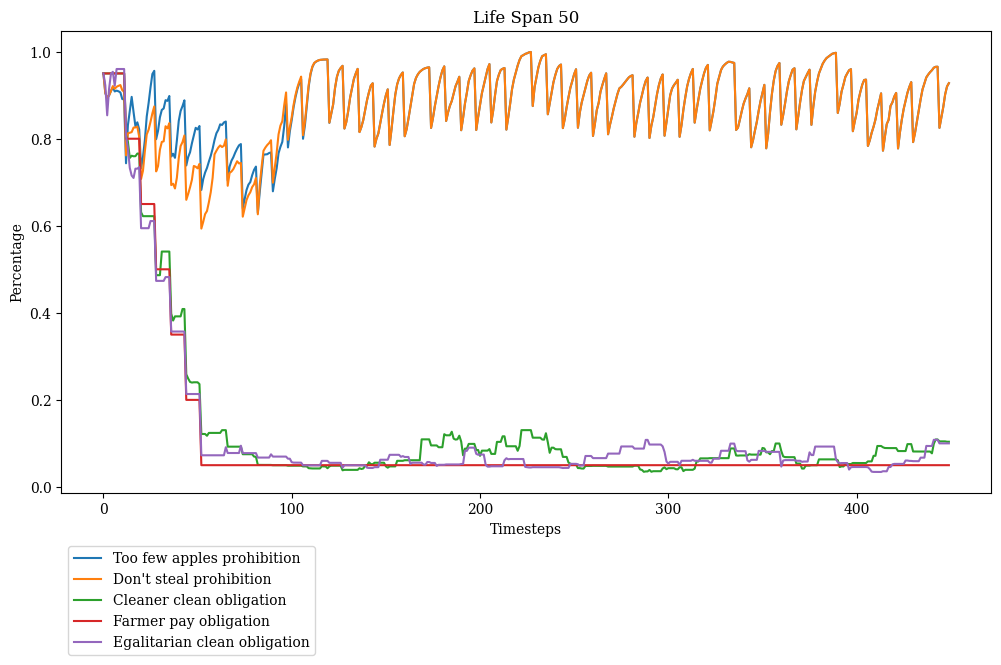

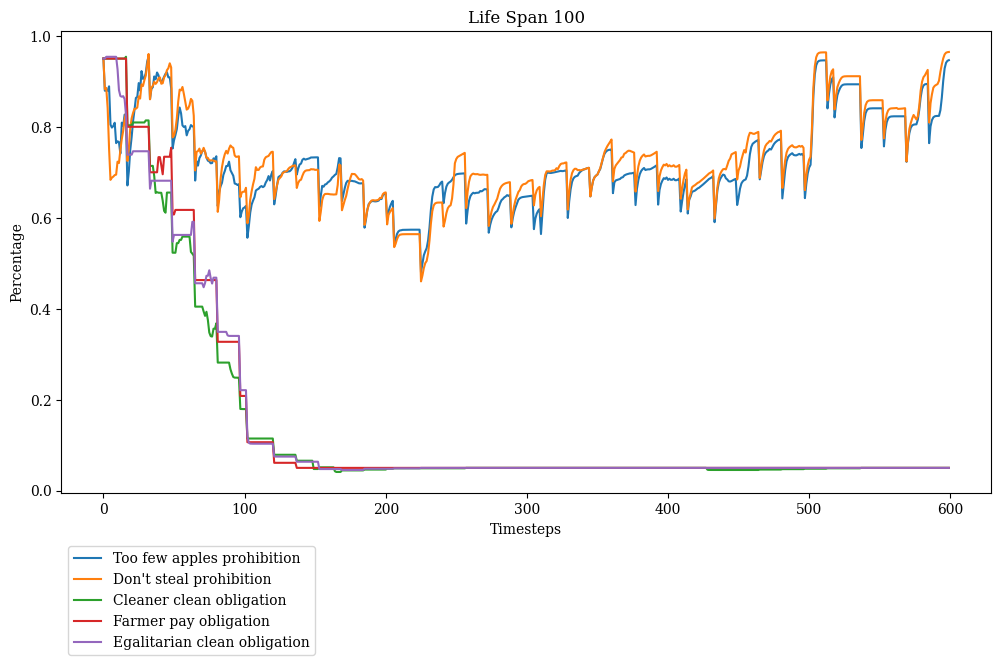

In [20]:
#with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):    
for life_span, bot_data in max_life_span_dfs.items():
    plt.figure(figsize=(12, 6))  # Adjust the figure size to make room for the legend
    plt.title(f"Life Span {life_span}")

    for rule, rule_description in all_rules.items():
        all_trials = []

        for bot_trials in bot_data:
            avg_bot_df = pd.concat(bot_trials).groupby(level=0).mean()
            all_trials.append(avg_bot_df[rule])

        avg_all_trials = pd.concat(all_trials, axis=1).mean(axis=1)
        plt.plot(avg_all_trials.index, avg_all_trials.values, label=rule_description)

    plt.xlabel('Timesteps')
    plt.ylabel('Percentage')
    
    # Place the legend to the right of the plot
    plt.legend(loc='upper left', bbox_to_anchor=(0.0, -0.1))
    
    # Adjust layout to prevent clipping
    #plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.savefig(figures_path+f'life_span_{life_span}'+'.pdf', format='pdf', dpi=300)
    plt.show()

In [21]:
def average_data(bot_data):
    all_trials = []
    for bot_trials in bot_data:
        avg_bot_df = pd.concat(bot_trials, axis=0).groupby(level=0).mean()
        all_trials.append(avg_bot_df)
        
    # Average over all bots, keeping the same columns
    avg_all_trials = pd.concat(all_trials).groupby(level=0).mean()
    return avg_all_trials

In [22]:
def stretch_dataframe(df, target_length):
    current_length = len(df)
    # Create an array representing the stretched indices
    stretched_indices = np.floor(np.linspace(0, current_length-1, target_length)).astype(int)
    
    # Use the stretched indices to populate a new DataFrame
    stretched_df = df.iloc[stretched_indices].reset_index(drop=True)
    return stretched_df

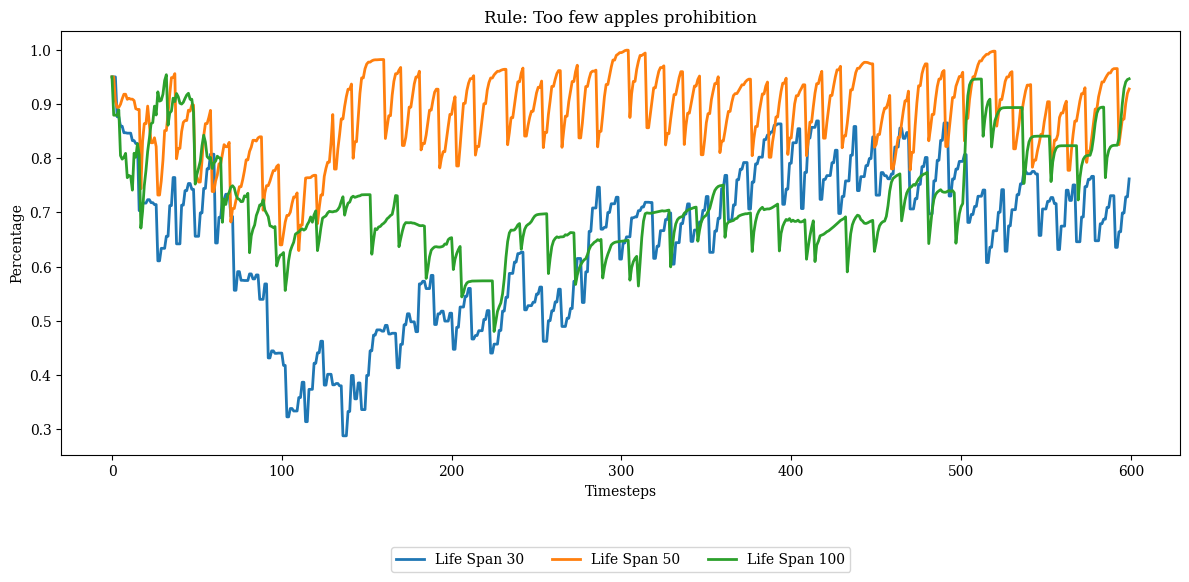

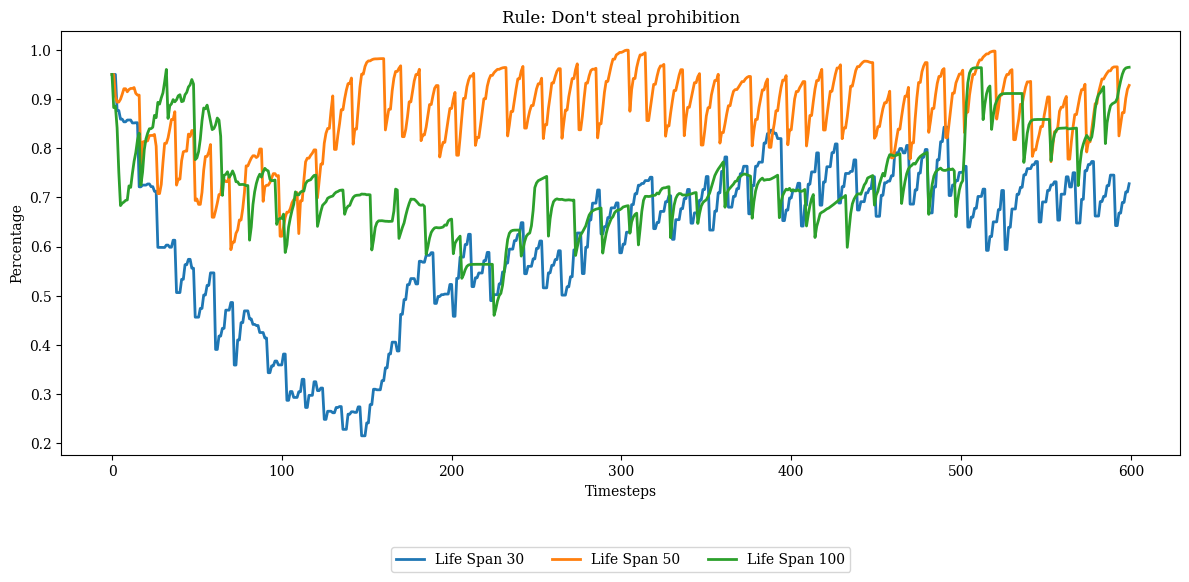

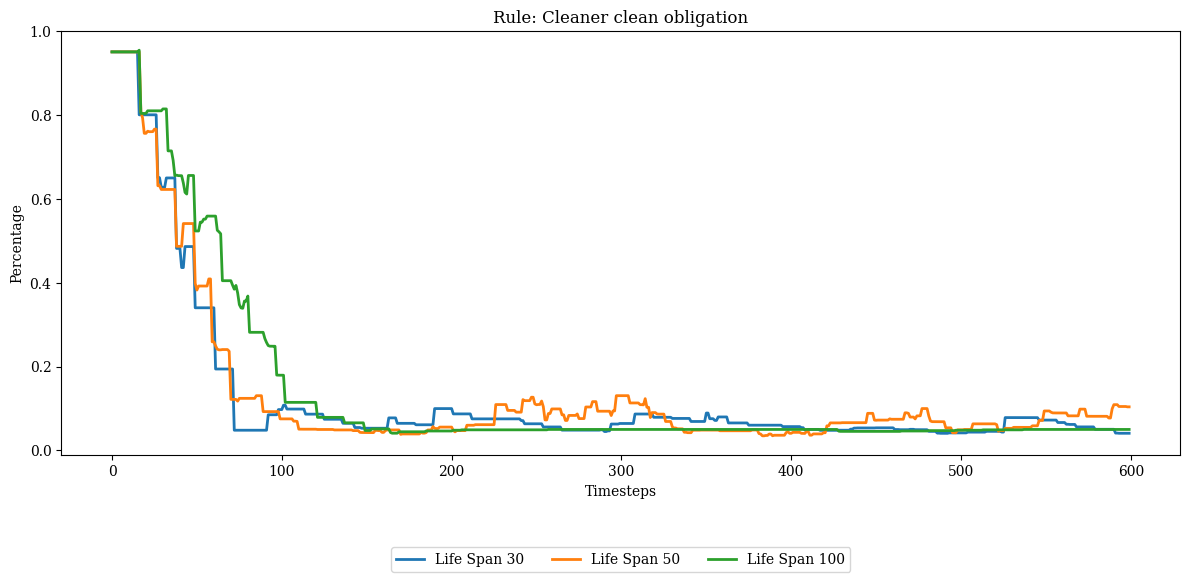

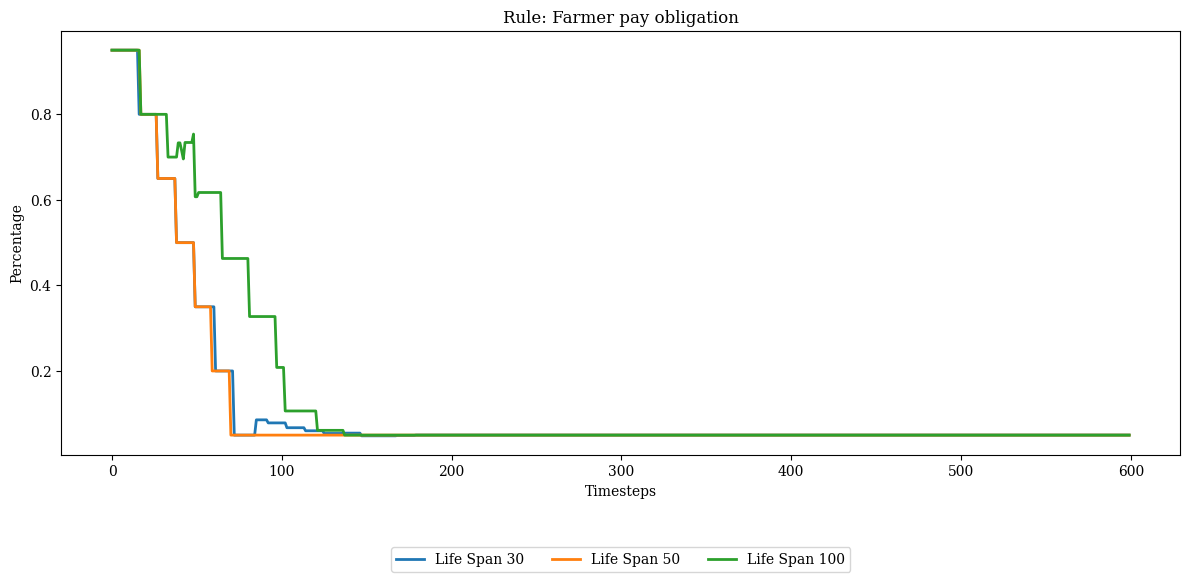

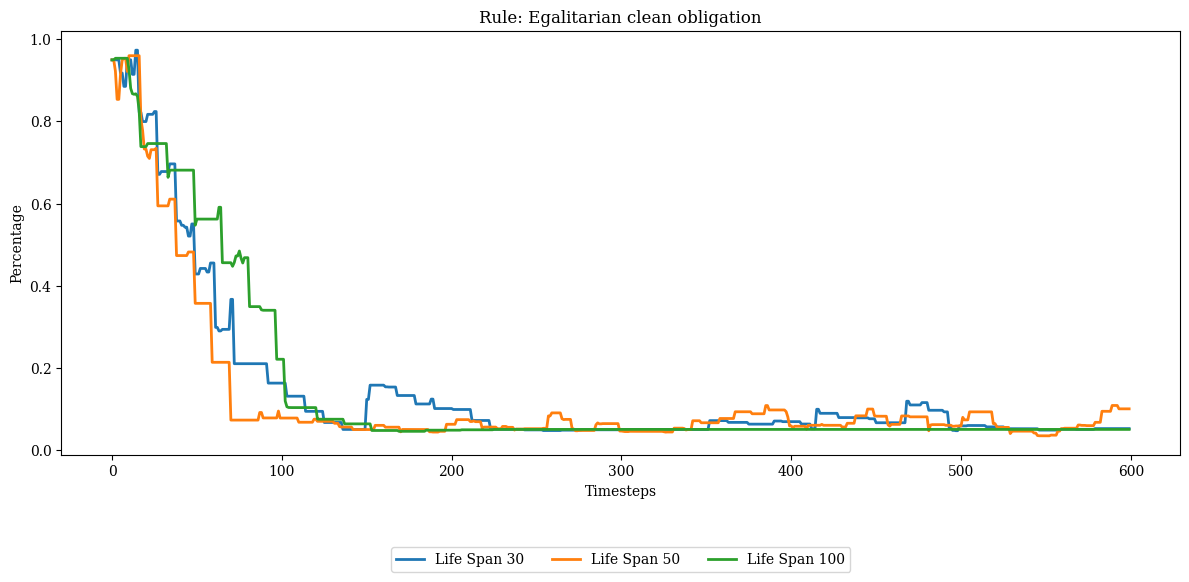

In [23]:
# Max timesteps among all life spans
max_timesteps = max(max_life_span_dfs.keys()) * 6  # 6 bots

#with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
# Loop through each rule and plot the data for both life spans
for rule, rule_description in all_rules.items():
    plt.figure(figsize=(12, 6))
    plt.title(f"Rule: {rule_description}")
    name = rule_description

    for life_span, bot_data in max_life_span_dfs.items():
        avg_all_trials = average_data(bot_data)  # Assuming average_data gives you averaged DataFrame
        current_timesteps = life_span * 6  # Current max timesteps for this life span

        # Check if stretching is needed
        if current_timesteps < max_timesteps:
            avg_all_trials = stretch_dataframe(avg_all_trials, max_timesteps)
        
        # Check if the rule exists in the DataFrame columns
        if rule in avg_all_trials.columns:
            plt.plot(avg_all_trials.index, avg_all_trials[rule], label=f"Life Span {life_span}", lw=2)


    plt.xlabel('Timesteps')
    plt.ylabel('Percentage')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.savefig(figures_path+f'{rule_description}'+'.pdf', format='pdf', dpi=300)
    plt.show()

# Basic Stats

## Correlation of Trials

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
def get_cosine_similarity(df_list: list):
        # Create an empty matrix to store the kappa values
    heatmap_data = np.zeros((13, 13))
    p_values = np.zeros((13, 13))
    num_settings = len(df_list)
    num_trials = len(df_list[0])

    for trial1 in range(num_trials):
        for trial2 in range(num_trials):
            # Accumulate the correlation values across all settings
            total_cosine = 0

            for i in range(num_settings):
                # Get the data for the current trials from the corresponding dataframes
                data1 = df_list[i][trial1]
                data2 = df_list[i][trial2]

                # Extract the posterior columns
                posterior_columns_1 = data1.columns[11:] 
                posterior_columns_2 = data2.columns[11:]

                # Get the posterior data for each trial
                posteriors_1 = data1[posterior_columns_1].values
                posteriors_2 = data2[posterior_columns_2].values

                # Handle NaN values
                posteriors_1[np.isnan(posteriors_1)] = 0
                posteriors_2[np.isnan(posteriors_2)] = 0
                
                # Calculate cosine similarity between trials
                cosine_sim = cosine_similarity(posteriors_1, posteriors_2)

                # Calculate the average cosine similarity for the current trial pair
                avg_cosine = cosine_sim.sum() / num_settings

            heatmap_data[trial1, trial2] = avg_cosine

    return heatmap_data


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Experiment Settings

# Pro-Social Behavior

Collected Data:

- A. Obtained Reward per Timestep per Agent
- B. Number of Dissceted Fields per Timesteo (Quantative Measure of Environment Destruction)

## A. Obtained Reward at Timestep for 
1. Baseline
2. Rule Combinations (all 4 agents)
3. Role Combination (all 5 rules)

In [ ]:
def get_mean_rewards_and_desiccated(df_list: list):
    # data is stored in a list of 32 lists called `data_list`
    averages = []
    num_settings = len(df_list)
    num_trials = len(df_list[0])

    for i in range(num_settings):
        mean_rewards = pd.DataFrame()
        mean_desiccated = pd.Series(0, index=range(len(df_list[0][0])))

        for j in range(num_trials):
            df = df_list[i][j] # Get the j-th dataframe for the i-th setting
            rewards = df.iloc[:, 1:5] # Get the first 4 columns (rewards per timestep)
            mean_rewards = mean_rewards.add(rewards, fill_value=0) # Add the rewards to the running sum in mean_rewards

            desiccated = df.iloc[:, 9]
            mean_desiccated = mean_desiccated.add(desiccated)

        mean_rewards = mean_rewards.divide(num_trials) # Divide the sum by the number of dataframes (8) to get the mean
        averages.append(mean_rewards)

    mean_desiccated = mean_desiccated / (num_settings * num_trials)
    average_rewards = pd.concat(averages).groupby(level=0).mean() # Concatenate all mean rewards and compute the average across all settings
    average_rewards_cum = average_rewards.cumsum() # Compute the cumulative average rewards

    return average_rewards_cum, mean_desiccated

In [ ]:
def get_mean_rewards_and_desiccated_per_setting(df):
        # data is stored in a list of 32 lists called `data_list`
    averages = []
    num_trials = len(df)

    mean_rewards = pd.DataFrame()
    mean_desiccated = pd.DataFrame()

    for i in range(num_trials):
        cur_df = df[i] # Get the j-th dataframe for the i-th setting
        rewards = cur_df.iloc[:, 1:5] # Get the first 4 columns (rewards per timestep)
        mean_rewards = mean_rewards.add(rewards, fill_value=0) # Add the rewards to the running sum in mean_rewards

        desiccated = cur_df.iloc[:, 9]
        #print(desiccated)
        mean_desiccated[i] = desiccated

    mean_rewards = mean_rewards.divide(num_trials) # Divide the sum by the number of dataframes (8) to get the mean
    averages.append(mean_rewards)

    mean_desiccated = mean_desiccated.mean(axis=1)
    average_rewards = pd.concat(averages).groupby(level=0).mean() # Concatenate all mean rewards and compute the average across all settings
    average_rewards_cum = average_rewards.cumsum() # Compute the cumulative average rewards

    return average_rewards_cum, mean_desiccated

In [ ]:
def plot_rewards_and_desiccated_baseline(average_rewards_cum: list, 
                                         mean_desiccated: list, 
                                         name: str) -> None:
    # Plot the rewards
    with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
        fig, ax1 = plt.subplots()
        # Plot each dimension with a different color
        for i, col in enumerate(average_rewards_cum.columns):
            if i == 0:
                plt.plot((average_rewards_cum[col])/2, linewidth=2.5)
            else:
                plt.plot(average_rewards_cum[col], linewidth=2.5)

        labels = ['1st Free Agent', 'Cleaner', 'Farmer', '2nd Free Agent']
        ax1.set_ylabel('Mean Rewards')
        ax1.set_xlabel("Timestep")
        ax1.legend(loc='upper left', labels=labels)

        # Create a secondary y-axis
        ax2 = ax1.twinx()
        ax2.plot(mean_desiccated, label='Mean desiccated Field Ratio', color='red', linestyle=':')
        ax2.set_ylabel('Mean desiccated Fields Ratio')
        ax2.set_ylim([0, 0.0009])
        ax2.legend(loc='upper center')

    plt.title(f'Cumulative Mean Reward and Mean Desiccated Ratio Across All Settings')
    plt.savefig(figures_path+name, dpi=300)
    plt.show()

In [ ]:
def plot_rewards_and_desiccated(average_rewards_cum: list, 
                                mean_desiccated: list, 
                                name: str) -> None:
    # Plot the rewards
    with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
        fig, ax1 = plt.subplots()
        # Plot each dimension with a different color
        for i, col in enumerate(average_rewards_cum.columns):
            plt.plot(average_rewards_cum[col], linewidth=2.5)

        labels = ['Free Agent', 'Cleaner', 'Farmer', 'Learner']
        ax1.set_ylabel('Mean Rewards')
        ax1.set_xlabel("Timestep")
        ax1.set_ylim([0,36])
        ax1.legend(loc='upper left', labels=labels)

        # Create a secondary y-axis
        ax2 = ax1.twinx()
        ax2.plot(mean_desiccated, label='Mean Desiccated Field Ratio', color='red', linestyle=':')
        ax2.set_ylabel('Mean desiccated Fields Ratio')
        ax2.set_ylim([0, 0.0009])
        ax2.legend(loc='upper center')

    plt.title(f'Average Cumulative Reward per Role + Average Ratio of Desiccated Fields')
    plt.savefig(figures_path+name, dpi=300)
    plt.show()

## B. Ratio of desiccated Fields per Timestep with Reward Data for 
1. Baseline
2. Rule Combinations (all 4 agents)
3. Role Combination (all 5 rules)

## B.1 Baseline
Ratio of desiccated Fields per Timesteo with Reward Data

In [ ]:
mean_rewards, mean_desiccated = get_mean_rewards_and_desiccated(baseline_dfs)

In [ ]:
plot_rewards_and_desiccated_baseline(mean_rewards, mean_desiccated, name="reward_desiccated_ratio_baseline")

## B.2 Rule Combinations (all 4 agents)
Ratio of desiccated Fields per Timesteo with Reward Data

In [ ]:
mean_rewards, mean_desiccated = get_mean_rewards_and_desiccated(rules_dfs)

In [ ]:
plot_rewards_and_desiccated(mean_rewards, mean_desiccated, name="reward_desiccated_ratio_rules")

## B.2 Role Combinations (all 5 rules)
Ratio of desiccated Fields per Timesteo with Reward Data

In [ ]:
mean_rewards, mean_desiccated = get_mean_rewards_and_desiccated(test_dfs)

In [ ]:
plot_rewards_and_desiccated(mean_rewards, mean_desiccated, name="reward_desiccated_ratio_roles")

# Rule Learning

Collected Data:

- A. Ratio of Learned Rules per Timestep per Rule (Line Graph)
- B. Percentage of Learned Rules at Certain Timesteps (Boxplot)
- C. Timesteps where Certain Percentage of Rules has been learned (Boxplot)
- D. F1 Scores for all Combinations

## Data Declarations for Legends

### Getting the set of active rules in regard to rule or role combination

In [ ]:
PROHIBITIONS = {
    'obs["CUR_CELL_HAS_APPLE"] and obs["NUM_APPLES_AROUND"] < 3 -> !MOVE_ACTION': "Prohibition: Don't collect apple if less than 3 apples around",
   'obs["CUR_CELL_HAS_APPLE"] and obs["CUR_CELL_IS_FOREIGN_PROPERTY"] -> !MOVE_ACTION': "Prohibition: Don't collect apple if it's on forgein territory",
}
OBLIGATION_CLEANER = {
    'obs["DIRT_FRACTION"] > 0.425 and obs["AGENT_LOOK"] == 1': "Obligation: If you're a cleaner, clean when the river is polluted to more than 42.5%",
}
OBLIGATION_FARMER = {
    'obs["SINCE_AGENT_LAST_PAID"] > 20 and obs["AGENT_LOOK"] == 2': "Obligation: If you're a farmer, pay your cleaner every 20 steps",
}
OBLIGATION_FREE = {
    'obs["DIRT_FRACTION"] > 0.45 and obs["AGENT_LOOK"] == 0': "Obligation: If you're egalitarian, clean when the river is polluted to more than 45%"
}
ACTIVE_RULES_PER_ROLE = [
    {},
    PROHIBITIONS | OBLIGATION_FREE,
    PROHIBITIONS | OBLIGATION_CLEANER,
    PROHIBITIONS,
    PROHIBITIONS | OBLIGATION_FREE | OBLIGATION_CLEANER,
    PROHIBITIONS | OBLIGATION_FREE,
    PROHIBITIONS | OBLIGATION_FARMER | OBLIGATION_CLEANER,
    PROHIBITIONS | OBLIGATION_FARMER | OBLIGATION_CLEANER | OBLIGATION_FREE
]
ALL_RULES_LIST = [
    {"obs['NUM_APPLES_AROUND'] < 3 and obs['CUR_CELL_HAS_APPLE'] -> !MOVE_ACTION": "Prohibition: Don't collect apple if less than 3 apples around"},
    { "obs['CUR_CELL_HAS_APPLE'] and not obs['AGENT_HAS_STOLEN'] -> !MOVE_ACTION": "Prohibition: Don't collect apple if it's on forgein territory"},
    OBLIGATION_CLEANER, OBLIGATION_FARMER, OBLIGATION_FREE
]

In [ ]:
def get_active_rules(i: int, setting: str):
    """Returns a list of active rules in regard to the setting"""
    if setting == 'rules':
        return [rule for rule in settings_lambda.iloc[i, 3].strip("(").strip(")").split(", ")]
    elif setting == 'test':
        return ACTIVE_RULES_PER_ROLE[i]
    return

In [ ]:
TEST_SETTING_NAME = [
    "Leaner",
    "Free + learner",
    "Cleaner + learner",
    "Farmer + learner",
    "Cleaner, free + learner",
    "Farmer, free + learner",
    "Cleaner, farmer + learner",
    "Cleaner, farmer, free + learner",
]

In [ ]:
X_LABELS_RULE_SETS = ["0",
                      "1.1*", "1.2", "1.3", "1.4", "1.5",
                      "2.1*", "2.2*", "2.3*", "2.4*", "2.5", "2.6", "2.7", "2.8", "2.9", "2.10",
                      "3.1*", "3.2*", "3.3*", "3.4*", "3.5*", "3.6", "3.7", "3.8", "3.9", "3.10",
                      "4.1*", "4.2*", "4.3*", "4.4*", "4.5",
                      "5*"]

In [ ]:
X_LABELS_ROLE_SETS = ["L", 
                      "EL", "CL", "FL",
                      "CEL", "EFL", "CFL",
                      "CEFL"
]

In [ ]:
X_LABELS_ROLE_BASELINE = ["C", "E", "F", 
                          "EE", "CE", "ED",
                          "CEE", "EEF", "CEF",
                          "CEEF"
]

In [ ]:
def get_x_labels(num_settings: int):
    if num_settings <= 8:
        return X_LABELS_ROLE_SETS
    elif num_settings <= 10:
        return X_LABELS_ROLE_BASELINE
    return X_LABELS_RULE_SETS

In [ ]:
def get_setting_name(i: int, setting_str: str) -> str:
    """Returns a printable setting of roles for legend."""
    if setting_str == 'test':
        return TEST_SETTING_NAME[i]
    else:
        return settings_names.iloc[i, 3].split(", ")

In [ ]:
ALL_RULES_LIST = PROHIBITIONS | OBLIGATION_FARMER | OBLIGATION_CLEANER | OBLIGATION_FREE

In [ ]:
# List of all rules
ALL_RULES = PROHIBITIONS | OBLIGATION_FARMER | OBLIGATION_CLEANER | OBLIGATION_FREE

## Declarations for Data of Interest (What Timesteps, What Percentages)

In [ ]:
target_percentages = [0.2, 0.4, 0.6, 0.8, 0.99]
target_timesteps = [0, 20, 40, 50, 80, 120, 150, 180, 199]
num_timesteps = len(target_percentages)
num_trials = 13

## Functions for Extracting Data of Interest

In [ ]:
LOGICALLY_CONSISTENT_RULES = [
    "obs['NUM_APPLES_AROUND'] < 1 and obs['CUR_CELL_HAS_APPLE'] -> !MOVE_ACTION",
    "obs['NUM_APPLES_AROUND'] < 2 and obs['CUR_CELL_HAS_APPLE'] -> !MOVE_ACTION",
    "obs['SINCE_AGENT_LAST_PAYED'] > 30 -> obs['SINCE_AGENT_LAST_PAYED'] < 30",
    "obs['SINCE_AGENT_LAST_CLEANED'] > 10 -> obs['SINCE_AGENT_LAST_CLEANED'] < 10",
    "obs['SINCE_AGENT_LAST_CLEANED'] > 15 -> obs['SINCE_AGENT_LAST_CLEANED'] < 15",
    "obs['SINCE_AGENT_LAST_CLEANED'] > 29 -> obs['SINCE_AGENT_LAST_CLEANED'] < 29"
]

In [ ]:
MOST_FREQUENT_FALSE_POSITIVES = { 
    "obs['TOTAL_NUM_CLEANERS'] == 1 -> !EAT_ACTION": "If the total number of cleaners is 1, don't eat",
    "obs['TOTAL_NUM_CLEANERS'] == 1 -> !MOVE_ACTION": "If the total number of cleaners is 1, don't move",
    "obs['ORIENTATION'] == 3 -> !MOVE_ACTION": "If you're facing west, don't move",
    "obs['ORIENTATION'] == 1 -> !MOVE_ACTION": "If you're facing east, don't move",
    "obs['ORIENTATION'] == 0 -> !EAT_ACTION": "If you're facing north, don't eat",
    "obs['ORIENTATION'] == 0 -> !MOVE_ACTION": "If you're facing north, don't move",
    "obs['CUR_CELL_HAS_APPLE'] -> !EAT_ACTION": "If you're standing on an apple cell, don't eat",
    "obs['POSITION'][0] == obs['POSITION'][1] -> !MOVE_ACTION": "If you're x and y coordinates are equal, don't move"
    }

In [ ]:
def extract_tp_and_fn(df_list: list, num_setting: int, percentage: float, timestep: int, setting_str: str):
    """
    F1 Extractions:
    
        Returns true positives and false negatives for active and nonactive rules 
            for a certain percentage at a certain timestep setting for a specific setting.
    """

    tp_active = 0
    fn_active = 0
    tp_nonactive = 0
    fn_nonactive = 0

    # print(f'percentage: {percentage}, timestep: {timestep}')

    for trial in range(num_trials):

        df = df_list[num_setting][trial]
        active_rules = get_active_rules(num_setting, setting_str)
        if "" in active_rules:
            active_rules.remove("")

        """if trial == 0:
            print(f'setting: {num_setting}')
            print(f'active_rules: {active_rules}')
            print(f'percentage: {percentage}')"""
        
        for rule in active_rules:
            if df.loc[timestep, rule] >= percentage:
                tp_active += 1
            else:
                fn_active += 1
                
        for column in df.iloc[:, 10:].columns:
            if column not in LOGICALLY_CONSISTENT_RULES:
                if column not in active_rules:
                    if df.loc[timestep, column] < percentage:
                        tp_nonactive += 1
                    else:
                        fn_nonactive += 1

    #print(f'tp_active: {tp_active}, fn_active: {fn_active}, tp_nonactive: {tp_nonactive}, fn_nonactive: {fn_nonactive}')

    return tp_active, fn_active, tp_nonactive, fn_nonactive

In [ ]:
def extract_and_average_highest_values(data: list) -> pd.DataFrame:
    highest_values = []
    column_names = set()
    num_settings = len(data)
    num_trials = len(data[0])

    for dfs in data:
        for df in dfs:
            column_names.update(df.columns)

    column_names = sorted(column_names)  # Sort the column names alphabetically
    column_names = column_names[10:]
    num_columns = len(column_names)

    for dfs in data:
        setting_values = []
        for df in dfs:
            column_values = df[column_names].values
            setting_values.append(column_values)

        setting_values = np.mean(setting_values, axis=0)
        highest_values.extend(setting_values)

    averaged_values = np.mean(highest_values, axis=0)

    result_df = pd.DataFrame({'Column': column_names, 'Average Highest Value': averaged_values})
    result_df = result_df.sort_values(by='Average Highest Value', ascending=False).reset_index(drop=True)

    return result_df

In [ ]:
    
#ow_labels = ["Rule 1", "Rule 2", "Rule 3", "Rule 4", "Rule 5", "Rule 6", "Rule 7", "Rule 8"]
def plot_highest_values(data: pd.DataFrame) -> None:
    with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
        plt.figure(figsize=(10, 6))
        plt.bar(data[12:]['Column'], data[12:]['Average Highest Value'])
        plt.xlabel('Column')
        plt.ylabel('Average Highest Value')
        plt.title('Averaged Highest Values by Column')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

In [ ]:
averaged_highest_values = extract_and_average_highest_values(rules_dfs)
plot_highest_values(averaged_highest_values)

In [ ]:
def extract_timesteps(input_dfs: pd.DataFrame, num_settings: int, setting_str: str,
                      target_percentages: list, target_timesteps: list):
    """
    Returns list of dicts with each dict representing one run with extracted posteriors.

        Dict Values:
            Setting:                index of setting (1 to 32 for rule, 1 to 8 for role combinations)
            Trial:                  index of trial (1 of 13)
            Dsicrete Timesteps:     list of timesteos x where x is ts where x > posterios y
            Discrete Percentages:   list of posterios for timesteps of interest
            All Values:             list of all posterios
            Num Active Rules:       number of active rules for this setting 
    """
    results = []
    for i in range(num_settings):
        for j in range(13):
            # Load the corresponding dataframe
            df = input_dfs[i][j]

            active_rules = get_active_rules(i, setting_str)
            if "" in active_rules:
                active_rules.remove("")
                
            # Extract only the active rules from the dataframe
            df_active = df[active_rules]
            num_active = len(active_rules)

            # Calculate the timesteps where the agent has learned 50%, 80%, and 100% of the rules
            learned = []
            for row in df_active.itertuples():
                if not len(df_active.columns) == 0:
                    learned.append(sum(row[1:]) / len(df_active.columns))
                else:
                    learned.append(sum(row[1:]))

            timesteps = []
            for target in target_percentages:
                flag = False
                for idx, percent in enumerate(learned):
                    if percent >= target:
                        timesteps.append(idx)
                        flag = True
                        break
                if flag == False:
                    timesteps.append(np.nan)

            # Calculate the percentage of rules learned at timesteps 10, 30, and 50
            percentages = []
            for target in target_timesteps:
                if not len(df_active.columns) == 0:
                    percentages.append(sum(df_active.iloc[target]) / len(df_active.columns))

                else:
                    percentages.append(sum(df_active.iloc[target]))

            # Store the results for this setting and trial
            results.append({'setting': i, 'trial': j, 'discrete_timesteps': timesteps, 
                            'discrete_percentages': percentages, 'all_values': learned,
                            'num_active_rules': num_active})

    return results

In [ ]:
def extract_active_rules(input_dfs: pd.DataFrame, num_settings: int, rules: list, setting_str: str):
    """
    Returns list of dicts with each dict representing one run with extracted rule posteriors.

        Dict Values:
            Setting:            index of setting (1 to 32 for rule, 1 to 8 for role combinations)
            Trial:              index of trial (1 of 13)
            Rule:               rule for this setting
            All Values:         list of all posteriors for this rule
    """
    results = []
    for i in range(num_settings):
        for j in range(13):
            # Load the corresponding dataframe
            df = input_dfs[i][j]

            active_rules = get_active_rules(i, setting_str)
            if "" in active_rules:
                active_rules.remove("")

            for idx, rule in enumerate(rules):
                # Extract only the active rules from the dataframe
                df_active = df[[rule]]

                learned = []
                for row in df_active.itertuples():
                    if not rule in active_rules:
                        learned.append(np.nan)
                    else:
                        if not len(df_active.columns) == 0:
                            learned.append(sum(row[1:]) / len(df_active.columns))
                        else:
                            learned.append(sum(row[1:]))

                # Step 4: Store the results for this setting and trial
                results.append({'setting': i, 'trial': j, 'rule': rule, 'rule_idx': idx, 'all_values': learned})

    return results

In [ ]:
def extract_all_rules(input_dfs: pd.DataFrame, num_settings: int, rules: list):
    """
    Returns list of dicts with each dict representing one run with extracted rule posteriors.

        Dict Values:
            Setting:            index of setting (1 to 32 for rule, 1 to 8 for role combinations)
            Trial:              index of trial (1 of 13)
            Rule:               rule for this setting
            All Values:         list of all posteriors for this rule
    """
    results = []
    for i in range(num_settings):
        for j in range(13):
            # Load the corresponding dataframe
            df = input_dfs[i][j]

            for idx, rule in enumerate(rules):
                # Extract only the active rules from the dataframe
                df_active = df[[rule]]

                learned = []
                for row in df_active.itertuples():
                    learned.append(sum(row[1:]))

                # Step 4: Store the results for this setting and trial
                results.append({'setting': i, 'trial': j, 'rule': rule, 'rule_idx': idx, 'all_values': learned})

    return results

## Function for Calculating F1


In [ ]:
def get_f1_score(tp, fn, tn, fp):
    """Returns F1 score for a number of tp, fn, tn, and fp"""
    if tp + fp == 0:
        tp = 1
    if tp + fn == 0:
        tp = 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    return precision, recall, f1_score
    

In [ ]:
def get_f1_across_settings_per_specific_ts_and_percentage(percentages: list, timesteps: list, df_list: list, settings_str: str):
    tp_total, fn_total, tn_total, fp_total = 0, 0, 0, 0
    num_settings = len(df_list)

    precision_vals = [[] for _ in range(len(percentages))]
    recall_vals = [[] for _ in range(len(percentages))]
    f1_vals = [[] for _ in range(len(percentages))]

    for p_idx, percentage in enumerate(percentages):
        for timestep in timesteps:
            for setting in range(num_settings):
                tp, fn, tn, fp = extract_tp_and_fn(df_list=df_list, 
                                                num_setting=setting, 
                                                percentage=percentage, 
                                                timestep=timestep, 
                                                setting_str=settings_str)

                tp_total += tp
                fn_total += fn
                tn_total += tn
                fp_total += fp
            
            num_combinations = num_trials * num_settings
            total_avg_tp = tp_total / num_combinations
            total_avg_fn = fn_total / num_combinations
            total_avg_tn = tn_total / num_combinations
            total_avg_fp = fp_total / num_combinations

            precision, recall, f1_score = get_f1_score(total_avg_tp, total_avg_fn, total_avg_tn, total_avg_fp)
            precision, recall, f1_score = round(precision, 3), round(recall, 3), round(f1_score, 3)

            precision_vals[p_idx].append(precision)
            recall_vals[p_idx].append(recall)
            f1_vals[p_idx].append(f1_score)

            # Print the results
            #print(f'Timestep {timestep}, percentage: {percentage}:\tPre: {precision}, Rec: {recall}, F1: {f1_score}')
            """print(f'Active rules TP: {total_avg_tp}')
            print(f'Non-active rules TP: {total_avg_fn}')
            print(f'Active rules FN: {total_avg_tn}')
            print(f'Non-active rules FN: {total_avg_fp}')"""

    return precision_vals, recall_vals, f1_vals

In [ ]:
def get_f1_across_timesteps_and_percentages(percentages: list, timesteps: list, df_list: list, settings_str: str):
    """Calculates F1 score across all settings for a combination as well as per setting"""
    tp_total, fn_total, tn_total, fp_total = 0, 0, 0, 0
    num_settings = len(df_list)

    precision_vals = []
    recall_vals = []
    f1_vals = []

    for setting in range(num_settings):
        tp_intermediate, fn_intermediate, tn_intermediate, fp_intermediate = 0, 0, 0, 0
            
        for timestep in timesteps:
            for percentage in percentages:
                tp, fn, tn, fp = extract_tp_and_fn(df_list=df_list, 
                                                num_setting=setting, 
                                                percentage=percentage, 
                                                timestep=timestep, 
                                                setting_str=settings_str)

                tp_total += tp
                fn_total += fn
                tn_total += tn
                fp_total += fp

                tp_intermediate += tp
                fn_intermediate += fn
                tn_intermediate += tn
                fp_intermediate += fp
        
        num_combinations_intermediate = len(percentages) * len(timesteps) * num_trials
        intermediate_avg_tp = tp_intermediate / num_combinations_intermediate
        intermediate_avg_fn = fn_intermediate / num_combinations_intermediate
        intermediate_avg_tn = tn_intermediate / num_combinations_intermediate
        intermediate_avg_fp = fp_intermediate / num_combinations_intermediate

        precision, recall, f1_score = get_f1_score(intermediate_avg_tp, intermediate_avg_fn, intermediate_avg_tn, intermediate_avg_fp)
        precision, recall, f1_score = round(precision, 3), round(recall, 3), round(f1_score, 3)

        precision_vals.append(precision)
        recall_vals.append(recall)
        f1_vals.append(f1_score)

        # Print the results
        #print(f'Setting {setting+1}:\tPre: {precision}, Rec: {recall}, F1: {f1_score}')
        """print(f'Active rules TP: {intermediate_avg_tp}')
        print(f'Non-active rules TP: {intermediate_avg_fn}')
        print(f'Active rules FN: {intermediate_avg_tn}')
        print(f'Non-active rules FN: {intermediate_avg_fp}')"""
            
    num_combinations = len(percentages) * len(timesteps) * num_trials * num_settings
    total_avg_tp = tp_total / num_combinations
    total_avg_fn = fn_total / num_combinations
    total_avg_tn = tn_total / num_combinations
    total_avg_fp = fp_total / num_combinations

    total_precision, total_recall, total_f1_score = get_f1_score(total_avg_tp, total_avg_fn, total_avg_tn, total_avg_fp)
    total_precision, total_recall, total_f1_score = round(total_precision, 3), round(total_recall, 3), round(total_f1_score, 3)

    # Print the results
    print(f'Across all settings, timesteps, and percentages:\tPre: {total_precision}, Rec: {total_recall}, F1: {total_f1_score}')
    """print(f'Active rules TP: {total_avg_tp}')
    print(f'Non-active rules TP: {total_avg_fn}')
    print(f'Active rules FN: {total_avg_tn}')
    print(f'Non-active rules FN: {total_avg_fp}')"""

    return precision_vals, recall_vals, f1_vals

In [ ]:
def get_sum_rewards_and_desiccated_per_setting(df_list: list):
    # data is stored in a list of 32 lists called `data_list`
    num_settings = len(df_list)
    num_trials = len(df_list[0])

    cum_rewards = []
    cum_desiccated = []

    num_agents = 4

    for i in range(num_settings):
        mean_rewards = pd.DataFrame()
        mean_desiccated_trial = []

        for j in range(num_trials):
            df = df_list[i][j] # Get the j-th dataframe for the i-th setting
            rewards = df.iloc[:, 1:5] # Get the first 4 columns (rewards per timestep)
            mean_rewards = mean_rewards.add(rewards, fill_value=0) # Add the rewards to the running sum in mean_rewards

            num_agents = df.iloc[:, 1:5].loc[:, (df.iloc[:, 1:6] != 0).any()].shape[1]

            desiccated = df.iloc[199, 9]
            mean_desiccated_trial.append(desiccated)

        mean_rewards = mean_rewards.divide(num_trials) # Divide the sum by the number of dataframes (8) to get the mean
        mean_rewards = mean_rewards.sum() / num_agents
        cum_rewards.append(mean_rewards.sum().sum())

        mean_desiccated_sum = sum(mean_desiccated_trial)
        mean_desiccated_sum = mean_desiccated_sum / num_trials
        cum_desiccated.append(mean_desiccated_sum)

    return cum_rewards, cum_desiccated

In [ ]:
def get_sum_rewards_learner(df_list: list):
    # data is stored in a list of 32 lists called `data_list`
    num_settings = len(df_list)
    num_trials = len(df_list[0])

    cum_rewards_learner = []

    for i in range(num_settings):
        mean_rewards = []

        for j in range(num_trials):
            df = df_list[i][j] # Get the j-th dataframe for the i-th setting
            rewards = df.iloc[:, 4] # get learner column
            reward_sum = sum(rewards)
            mean_rewards.append(reward_sum)

        cum_rewards_learner.append((sum(mean_rewards)/num_trials))

    return cum_rewards_learner

## Functions for Plotting

In [ ]:
# Assuming your data frame is called 'df' and contains the relevant columns
def plot_cosine_similarity(cosine_sim: list, name: str):
    # Create a MinMaxScaler object
    scaler = MinMaxScaler(feature_range=(-1, 1))
    # Normalize the data using Min-Max normalization
    normalized_data = scaler.fit_transform(cosine_sim)

    with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
        plt.figure(figsize=(9, 6.5))
        sns.heatmap(normalized_data, annot=False, fmt=".2f", linewidths=0.5, cbar=True)
        plt.xlabel('Trial Index')
        plt.ylabel('Trial Index')
        plt.title(f"Cosine Similarity Matrix")
        plt.savefig(figures_path+name, dpi=300)
        plt.show()

In [ ]:
def plot_timestep_per_percentage(continuous_timesteps: list, 
                                 percentage: float,
                                 name: str) -> None:
    """Plots timestep at what a rule has reached a certain posterior, grouped by setting."""

    num_settings = len(continuous_timesteps)
    labels = [f'S{i+1}' for i in range(num_settings)]
    num_trials = len(continuous_timesteps[0])
    num_timesteps = len(continuous_timesteps[0][0])

    x_ticks = [""] + get_x_labels(num_settings)

    with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
        plt.figure(figsize=(12, 4))
        boxplot_data = [[] for _ in range(num_settings)]
        for idx in range(num_settings):
            data = []
            for i in range(num_trials): # num trials
                for j in range(num_timesteps): # num timesteps
                    if continuous_timesteps[idx][i][j] >= percentage:
                        data.append(j)
                        break
            cleandata= [x for x in data if str(x) != 'nan']
            boxplot_data[idx] = cleandata
            
        boxplot = plt.boxplot(boxplot_data, labels=labels, patch_artist=True)

        yellow = "#F79800"
        salmon = "#FF8156"
        pink = "#EE3568"
        violet = "#8C1985"
        blue = "#5d2cb2"
        color_palette = [salmon, violet, pink, yellow, blue] 

        if num_settings > 10:
            # Define the groups to connect with brackets
            groups_to_bracket = [[2, 6], [7, 16], [17, 26], [27, 31]]  # Adjust the indices as needed
            y_coord = 205
            bracket_labels = ["1 Rule", "2 Rules", "3 Rules", "4 Rules"]

            # Assign colors to the box plots based on the groups
            for idx, box in enumerate(boxplot['boxes']):
                group_index = None
                for i, group in enumerate(groups_to_bracket):
                    if idx in range(group[0]-1, group[1]):
                        group_index = i
                        break
                if group_index is not None:
                    box.set_facecolor(color_palette[group_index])
                else:
                    box.set_facecolor(color_palette[4])

            for group_index in range(len(groups_to_bracket)):
                group = groups_to_bracket[group_index]
                label = bracket_labels[group_index]
                x_start = group[0] - 0.3
                x_end = group[-1] + 0.3
                plt.plot([x_start, x_end], [y_coord, y_coord], '-', linewidth=1.5, marker='|', markersize=10, color=color_palette[group_index])
                x_center = np.mean(group)
                plt.text(x_center, y_coord + 10, label, ha='center', va='center')
                        
    plt.xlabel('Setting')
    plt.ylabel('Timesteps')
    plt.xticks(range(len(x_ticks)), x_ticks)
    plt.ylim([0, 230])
    plt.title(f'Number of Timesteps for Accuracy of {int(percentage*100)}%, by Setting')
    plt.savefig(figures_path+name, dpi=300)
    plt.show()

In [ ]:
def plot_percentage_per_timestep(continuous_timesteps: list, 
                                 timestep: int, 
                                 name: str) -> None:
    """Plots posterior that was reached at certain timestep, grouped by setting."""
    
    num_settings = len(continuous_timesteps)
    labels = [f'S{i+1}' for i in range(num_settings)]
    x_ticks = [""] + get_x_labels(num_settings)

    with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
        plt.figure(figsize=(12, 4))
        boxplot_data = [[] for _ in range(num_settings)]
        for idx in range(num_settings):
            data = []
            for i in range(num_trials):
                data.append(continuous_timesteps[idx][i][timestep])
            cleandata= [x for x in data if str(x) != 'nan']
            boxplot_data[idx] = cleandata
            
        boxplot = plt.boxplot(boxplot_data, labels=labels, patch_artist=True)

        yellow = "#F79800"
        salmon = "#FF8156"
        pink = "#EE3568"
        violet = "#8C1985"
        blue = "#5d2cb2"
        color_palette = [salmon, violet, pink, yellow, blue] 

        if num_settings > 10:
            # Define the groups to connect with brackets
            groups_to_bracket = [[2, 6], [7, 16], [17, 26], [27, 31]]  # Adjust the indices as needed
            y_coord = 1.05
            bracket_labels = ["1 Rule", "2 Rules", "3 Rules", "4 Rules"]

            # Assign colors to the box plots based on the groups
            for idx, box in enumerate(boxplot['boxes']):
                group_index = None
                for i, group in enumerate(groups_to_bracket):
                    if idx in range(group[0]-1, group[1]):
                        group_index = i
                        break
                if group_index is not None:
                    box.set_facecolor(color_palette[group_index])
                else: 
                    box.set_facecolor(color_palette[4])

            for group_index in range(len(groups_to_bracket)):
                group = groups_to_bracket[group_index]
                label = bracket_labels[group_index]
                x_start = group[0] - 0.3
                x_end = group[-1] + 0.3
                plt.plot([x_start, x_end], [y_coord, y_coord], '-', linewidth=1.5, marker='|', markersize=10, color=color_palette[group_index])
                x_center = np.mean(group)
                plt.text(x_center, y_coord + 0.05, label, ha='center', va='center')
        
    plt.xlabel('Setting')
    plt.xticks(range(len(x_ticks)), x_ticks)
    plt.ylabel('Percentage of Rules Learned')
    plt.ylim([0, 1.2])
    plt.title(f'Percentage of Learned Rules at Timestep {timestep}, by Setting')
    plt.show()


In [ ]:
def plot_all_timesteps_per_percentage(all_values: list, 
                                      setting_str: str, 
                                      name: str) -> None:
    """Plots continuous posteriors for each timestep, grouped by setting."""

    with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
        plt.figure(figsize=(12,6))
        for setting in range(len(all_values)):
            setting_timesteps = np.array(all_values[setting])
            mean_timesteps = np.nanmean(setting_timesteps, axis=0)
            setting_name = get_setting_name(setting, setting_str)
            plt.errorbar([*range(len(mean_timesteps))], mean_timesteps, label=f'{setting_name}', linewidth=2.5)

    plt.legend()
    plt.xlabel('Timestep')
    plt.ylabel('Percentage')
    plt.ylim([0, 1.1])
    plt.title('Percentage of Learned Rules per Timestep, by Setting')
    plt.show()

In [ ]:
def plot_single_rule_learning(rules: dict, 
                              all_values: list, 
                              name: str) -> None:
    """Plots posterior of rule at certain timestep, grouped by rule."""

    with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
        plt.figure(figsize=(10,4))
        for idx, rule in enumerate(rules.keys()):
            rule_name = rules[rule]

            averaged_data = np.nanmean(all_values[idx], axis=(0, 1))

            if len(rules.keys()) == 4:
                averaged_data = averaged_data * 1.66

            plt.plot(averaged_data, label=rule_name, linewidth=2, linestyle="-")

    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Timesteps')
    plt.ylabel('Percentage')
    plt.ylim([0, 1.1])
    plt.title('Percentage of Learned Rules per Timestep, by Rule')
    plt.savefig(figures_path+name, dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
def plot_rule_after_timestep_x(all_values: list, 
                               timestep: int, 
                               name: str) -> None:
    """Plots rule posterior after timestep x, grouped by rule"""

    labels = ['Pr1', 'Pr2', 'Ob1', 'Ob2', 'Ob3']
    colors = ['pink', 'lightblue', 'lightgreen', 'lightblue', 'pink']

    num_rules = len(all_values)
    num_settings = len(all_values[0])
    num_trials = len(all_values[0][0])

    with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
        plt.figure(figsize=(6, 4))
        boxplot_data = [[] for _ in range(num_rules)]
        for idx in range(len(ALL_RULES)):
            data = []
            for i in range(num_settings):
                for j in range(num_trials):
                    data.append(all_values[idx][i][j][timestep])
            cleandata= [x for x in data if str(x) != 'nan']
            boxplot_data[idx] = cleandata

        bplot = plt.boxplot(boxplot_data, labels=labels, patch_artist=True)
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)
        
    plt.xlabel('Rule (Pr for Prohibition, Ob for Obligation)')
    plt.ylabel('Percentage of Rules Learned')
    plt.ylim([0, 1.1])
    plt.title(f'Percentage of Learned Rule at Timestep {timestep}')
    plt.show()


In [ ]:
def plot_rule_timestep_at_percentage(all_values: list, 
                                    percentage: float, 
                                    name: str) -> None:
    """Plots timestep at what a rule has reached a certain posterior, grouped by rule."""

    labels = ['Pr1', 'Pr2', 'Ob1', 'Ob2', 'Ob3']
    colors = ['pink', 'lightblue', 'lightgreen', 'lightblue', 'pink']

    num_rules = len(all_values)
    num_settings = len(all_values[0])
    num_trials = len(all_values[0][0])
    num_timesteps = len(all_values[0][0][0])

    with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
        plt.figure(figsize=(6, 4))
        boxplot_data = [[] for _ in range(num_rules)]
        for idx in range(num_rules):
            data = []
            for i in range(num_settings):
                for j in range(num_trials):
                    for h in range(num_timesteps):
                        if all_values[idx][i][j][h] >= percentage:
                            data.append(h)
                            break
            cleandata= [x for x in data if str(x) != 'nan']
            boxplot_data[idx] = cleandata
            
        bplot = plt.boxplot(boxplot_data, labels=labels, patch_artist=True)
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)
        
    plt.xlabel('Rule (Pr for Prohibition, Ob for Obligation)')
    plt.ylabel('Timesteps')
    plt.ylim([0, 210])
    plt.title(f'Number of Timesteps for Learning {int(percentage*100)}% of the Rules, by Rule')
    plt.show()

In [ ]:
def plot_pre_rec_f1(precision_values: list, 
                    recall_values: list, 
                    f1_values: list, 
                    timesteps: list, 
                    name: str) -> None:
    # Plotting precision, recall, and F1
    labels = [0.2, 0.4, 0.6, 0.8, 0.99]  # Posteriors
    num_f1_vals = len(f1_values)
    
    with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
        fig, axs = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

        for i in range(num_f1_vals):
            axs[0].plot(timesteps, precision_values[i], label=f'Precision for {labels[i]}', marker='o')
            axs[1].plot(timesteps, recall_values[i], label=f'Recall for {labels[i]}', marker='s')
            axs[2].plot(timesteps, f1_values[i], label=f'F1 for {labels[i]}', marker='^')

        # Configure subplots
        axs[0].set_ylabel('Precision')
        axs[1].set_ylabel('Recall')
        axs[2].set_ylabel('F1')
        axs[2].set_xlabel('Time Steps')

        axs[0].legend(loc='upper right')
        axs[1].legend(loc='upper right')
        axs[2].legend(loc='upper right')

        plt.tight_layout()
        plt.show()

In [ ]:
def plot_avg_pre_rec_f1(precision_values: list, 
                        recall_values: list, 
                        f1_values: list, 
                        timesteps: list, 
                        name: str) -> None:
    avg_precision = np.mean(precision_values, axis=0)
    avg_recall = np.mean(recall_values, axis=0)
    avg_f1 = np.mean(f1_values, axis=0)

    with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
        plt.figure(figsize=(8, 6))

        plt.plot(timesteps, avg_precision, label='Average Precision', marker='o')
        plt.plot(timesteps, avg_recall, label='Average Recall', marker='s')
        plt.plot(timesteps, avg_f1, label='Average F1', marker='^')

        plt.xlabel('Time Steps')
        plt.ylabel('Score')
        plt.ylim([0, 1.1])
        plt.title('Average Precision, Recall, and F1 Scores Across All Settings')
        plt.legend()
        plt.grid(True)
        plt.show()

In [ ]:
def plot_avg_pre_rec_f1_per_setting(precision_values: list, 
                                    recall_values: list, 
                                    f1_values: list, 
                                    name: str) -> None:
    num_settings = len(precision_values)
    x_ticks = get_x_labels(num_settings)
    
    with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
        plt.figure(figsize=(14, 6))
        settings = np.arange(num_settings)
        yellow = "#F79800"
        orange = "#E57D7B"
        red = "#C05D7A"

        plt.bar(settings, recall_values, label='Recall', color=yellow)
        plt.bar(settings, f1_values, label='F1', color=orange)
        plt.bar(settings, precision_values, label='Precision', color=red)

        if num_settings > 10:
            # Define the groups to connect with brackets
            groups_to_bracket = [[1, 5], [6, 15], [16, 25], [26, 30]]  # Adjust the indices as needed
            y_coord = 0.9
            bracket_labels = ["1 Rule", "2 Rules", "3 Rules", "4 Rules"]

            # Add brackets
            for group, label in zip(groups_to_bracket, bracket_labels):
                x_start = group[0] - 0.3
                x_end = group[-1] + 0.3
                plt.plot([x_start, x_end], [y_coord, y_coord], '-', linewidth=1.5, marker='|', markersize=10)

            # Add labels
            for i, label in enumerate(bracket_labels):
                x_center = np.mean(groups_to_bracket[i])
                plt.text(x_center, y_coord - 0.03, label, ha='center', va='center')

        plt.xlabel('Setting Index')
        plt.xticks(range(len(x_ticks)), x_ticks)
        plt.ylabel('Score')
        plt.ylim([0, 1.1])
        plt.title('Average Precision, Recall, and F1 Scores by Setting')
        plt.legend()
        plt.grid(True)
        plt.savefig(figures_path+name, dpi=300)
        plt.show()

In [ ]:
def plot_reward_and_rule_learning_per_setting(rules: dict, 
                                  all_values: list, 
                                  mean_rewards: pd.DataFrame, 
                                  mean_desiccated: list, 
                                  name: str) -> None:
    """Plots posterior of rule at certain timestep, grouped by rule, along with mean rewards."""

    with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
        fig, ax1 = plt.subplots(figsize=(10, 4))
        ax2 = ax1.twinx()
        ax3 = ax1.twinx()

        # Offset the third axis
        ax3.spines.right.set_position(("outward", 60))
        ax3.spines.right.set_visible(True)

        for idx, rule in enumerate(rules.keys()):
            rule_name = rules[rule]

            # Assuming your array is named 'data'
            averaged_data = np.nanmean(all_values[idx], axis=(0, 1))
            
            if not np.allclose(averaged_data, 0):  # Exclude rules with only 0 values
                ax1.plot(averaged_data, label=rule_name, linewidth=2.5)

        learner_rewards = mean_rewards['learner']
        ax2.plot(learner_rewards, color='black', linestyle='--', label='Mean Reward for Learner')

        desiccated_ratio = mean_desiccated / 200  # Assuming you have 200 timesteps
        ax3.plot(desiccated_ratio, color='red', linestyle=':', label='Desiccated Field Ratio')

        ax1.set_xlabel('Timesteps')
        ax1.set_ylabel('Percentage of Learned Rules')
        ax1.set_ylim([0, 1.1])
        ax2.set_ylabel('Mean Rewards')
        ax2.set_ylim([0, 35])
        ax3.set_ylabel('Desiccated Field Ratio')
        ax3.set_ylim([0, 0.0009])
        ax1.set_title('Percentage of Learned Rules, Learner Reward, and Desiccated Fields per Timestep, by Rule')

        handles1, labels1 = ax1.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        handles3, labels3 = ax3.get_legend_handles_labels()

        handles = handles1 + handles2 + handles3
        labels = labels1 + labels2 + labels3

        #ax1.legend(handles, labels, bbox_to_anchor=(1.22, 1), loc=2, borderaxespad=0.)

        plt.savefig(figures_path + name, dpi=300, bbox_inches='tight')
        plt.show()


In [ ]:
def plot_reward_and_rule_learning(rules: dict, 
                                  all_values: list, 
                                  mean_rewards: pd.DataFrame, 
                                  mean_desiccated: list, 
                                  name: str) -> None:
    """Plots posterior of rule at certain timestep, grouped by rule, along with mean rewards."""

    with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
        fig, ax1 = plt.subplots(figsize=(10, 4))
        ax2 = ax1.twinx()
        ax3 = ax1.twinx()

        # Offset the third axis
        ax3.spines.right.set_position(("outward", 60))
        ax3.spines.right.set_visible(True)

        for idx, rule in enumerate(rules.keys()):
            rule_name = rules[rule]

            # Assuming your array is named 'data'
            averaged_data = np.nanmean(all_values[idx], axis=(0, 1))
            ax1.plot(averaged_data, label=rule_name, linewidth=2.5)

        learner_rewards = mean_rewards['learner']
        ax2.plot(learner_rewards, color='black', linestyle='--', label='Mean Reward for Learner')

        desiccated_ratio = mean_desiccated / 200  # Assuming you have 200 timesteps
        ax3.plot(desiccated_ratio, color='red', linestyle=':', label='Desiccated Field Ratio')

        ax1.set_xlabel('Timesteps')
        ax1.set_ylabel('Percentage of Learned Rules')
        ax1.set_ylim([0, 1.1])
        ax2.set_ylabel('Mean Rewards')
        ax2.set_ylim([0, 35])
        ax3.set_ylabel('Desiccated Field Ratio')
        ax3.set_ylim([0, 0.0009])
        ax1.set_title('Percentage of Learned Rules, Learner Reward, and Desiccated Fields per Timestep, by Rule')

        # Combine legends for ax1 and ax2
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        lines3, labels3 = ax3.get_legend_handles_labels()
        lines = lines1 + lines2 + lines3
        labels = labels1 + labels2 + labels3
        ax1.legend(lines, labels, bbox_to_anchor=(1.22, 1), loc=2, borderaxespad=0.)

        plt.savefig(figures_path+name, dpi=300, bbox_inches='tight')
        plt.show()

In [ ]:
def plot_relation_desiccated_active_rules(cum_rewards: list, 
                                          cum_desiccated: list, 
                                          name: str, 
                                          learner=False) -> None:
    
    title = "Ratio of Desiccated Fields + Cumulative Shared Reward by Setting"
    x_ticks = get_x_labels(len(cum_rewards))
    with plt.style.context("/tmp/rose-pine-dawn.mplstyle"):
        # x_ticks = x_ticks[2:] uncomment for baseline
        x = range(len(x_ticks))[2:]
        plt.figure(figsize=(16, 6))
        # Define color map
        color_map = plt.cm.get_cmap('magma')

        # Normalize color values to range [0, 1]
        norm = plt.Normalize(min(cum_rewards), max(cum_rewards))
        color_values_normalized = norm(cum_rewards)
        barplot = plt.bar(x, cum_desiccated[2:], color=color_map(color_values_normalized))
        
        sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm)
        cbar.set_label('Cumulative Rewards')

        if len(cum_rewards) > 10:
            # Define the groups to connect with brackets
            groups_to_bracket = [[1, 5], [6, 15], [16, 25], [26, 30]]  # Adjust the indices as needed
            y_coords = [1.2, 1.0, 0.6, 0.3]
            bracket_labels = ["1 Rule", "2 Rules", "3 Rules", "4 Rules"]

            for group_index in range(len(groups_to_bracket)):
                group = groups_to_bracket[group_index]
                label = bracket_labels[group_index]
                x_start = group[0] - 0.3
                x_end = group[-1] + 0.3
                y_coord = y_coords[group_index]
                plt.plot([x_start, x_end], [y_coord, y_coord], '--', linewidth=1.2, marker='|', markersize=10, color="grey")
                x_center = np.mean(group)
                plt.text(x_center, y_coord + 0.025, label, ha='center', va='center')
        
        plt.xlabel('Number of Setting')
        plt.xticks(range(len(x_ticks))[2:], x_ticks[2:])
        plt.ylabel('Ratio of Desiccated Fields')
        if learner:
            title = "Ratio of Desiccated Fields + Learner Reward by Setting"
        plt.title(title)
        plt.savefig(figures_path+name, dpi=300)
        plt.show()

# A. Ratio of Learned Rules per Timestep per Setting

In [ ]:
cum_rewards, cum_desiccated = get_sum_rewards_and_desiccated_per_setting(df_list=baseline_dfs)
cum_reward_learner = get_sum_rewards_learner(baseline_dfs)
plot_relation_desiccated_active_rules(cum_reward_learner, cum_desiccated, name="learner_reward_desiccated_baseline", learner=True)
plot_relation_desiccated_active_rules(cum_rewards, cum_desiccated, name="cum_reward_desiccated_baseline")

## A.1 Ratio of Learned Rules — Rule Combinations

In [ ]:
num_settings = 32
setting_str = 'rules' # 'rules' or 'test'
df_list = rules_dfs

timestep_results = extract_timesteps(input_dfs=df_list, num_settings=num_settings, setting_str=setting_str,
                target_percentages=target_percentages, target_timesteps=target_timesteps)

single_rule_results = extract_active_rules(input_dfs=df_list, num_settings=num_settings, rules=ALL_RULES, setting_str=setting_str)

percentages_all = [[[0 for _ in range(num_timesteps)] for _ in range(num_trials)] for _ in range(num_settings)]
timesteps_all = [[[0 for _ in range(num_timesteps)] for _ in range(num_trials)] for _ in range(num_settings)]
continuous_timesteps = [[[] for _ in range(num_trials)] for _ in range(num_settings)]
continuous_rules = [[[0 for _ in range(num_trials)] for _ in range(num_settings)] for _ in range(len(ALL_RULES))]

for result in timestep_results:
    setting = result['setting']
    trial = result['trial']
    timesteps = result['discrete_timesteps']
    percentages = result['discrete_percentages']
    all_values = result['all_values']
    continuous_timesteps[setting][trial] = all_values
    
    for i in range(num_timesteps):
        timestep = i
        timesteps_all[setting][trial][timestep] = timesteps[i]
        percentages_all[setting][trial][timestep] = percentages[i]

continuous_timesteps_1 = continuous_timesteps[:6]
continuous_timesteps_2 = continuous_timesteps[6:15]
continuous_timesteps_3 = continuous_timesteps[15:26]
continuous_timesteps_4 = continuous_timesteps[26:]

for result in single_rule_results:
    setting = result['setting']
    trial = result['trial']
    rule = result['rule']
    rule_idx = result['rule_idx']
    all_values = result['all_values']
    continuous_rules[rule_idx][setting][trial] = all_values


In [ ]:
#cur_cosine_sim = get_cosine_similarity(df_list=df_list)

In [ ]:
#plot_cosine_similarity(cosine_sim=cur_cosine_sim, name="cosine_rules")

### Settings for 0-1 active rule

In [ ]:
plot_all_timesteps_per_percentage(
    all_values=continuous_timesteps_1, setting_str=setting_str, name="percentage_learner_per_setting_rules_1"
)

### Settings for 2 active rules

In [ ]:
plot_all_timesteps_per_percentage(
    all_values=continuous_timesteps_2, setting_str=setting_str, name="percentage_learner_per_setting_rules_2"
)

### Settings for 3 active rules

In [ ]:
plot_all_timesteps_per_percentage(
    all_values=continuous_timesteps_3, setting_str=setting_str, name="percentage_learner_per_setting_rules_3"
)

### Settings for 4-5 active rules

In [ ]:
plot_all_timesteps_per_percentage(
    all_values=continuous_timesteps_4, setting_str=setting_str, name="percentage_learner_per_setting_rules_4"
)

## B.1 Ratio of Learned Rules — Per Rule, Rule Combinations

In [ ]:
single_rule_results_fp = extract_all_rules(input_dfs=df_list, num_settings=num_settings, rules=MOST_FREQUENT_FALSE_POSITIVES)
continuous_rules_fp = [[[0 for _ in range(num_trials)] for _ in range(num_settings)] for _ in range(len(MOST_FREQUENT_FALSE_POSITIVES))]

for result in single_rule_results_fp:
    setting = result['setting']
    trial = result['trial']
    rule = result['rule']
    rule_idx = result['rule_idx']
    all_values = result['all_values']
    continuous_rules_fp[rule_idx][setting][trial] = all_values

plot_single_rule_learning(
    rules=MOST_FREQUENT_FALSE_POSITIVES, all_values=continuous_rules_fp, name="avg_rule_per_timestep_rules"
)

In [ ]:
plot_single_rule_learning(
    rules=ALL_RULES, all_values=continuous_rules, name="avg_rule_per_timestep_rules"
)

In [ ]:
PROHIBITION_HARVEST = {
    "obs['NUM_APPLES_AROUND'] < 1 and obs['CUR_CELL_HAS_APPLE'] -> !MOVE_ACTION": "Less than 1 apple around.",
    "obs['NUM_APPLES_AROUND'] < 2 and obs['CUR_CELL_HAS_APPLE'] -> !MOVE_ACTION": "Less than 2 apple around.",
    "obs['NUM_APPLES_AROUND'] < 3 and obs['CUR_CELL_HAS_APPLE'] -> !MOVE_ACTION": "Less than 3 apple around (True).",
    "obs['NUM_APPLES_AROUND'] < 4 and obs['CUR_CELL_HAS_APPLE'] -> !MOVE_ACTION": "Less than 4 apple around.",
    "obs['NUM_APPLES_AROUND'] < 5 and obs['CUR_CELL_HAS_APPLE'] -> !MOVE_ACTION": "Less than 5 apple around.",
    "obs['NUM_APPLES_AROUND'] < 6 and obs['CUR_CELL_HAS_APPLE'] -> !MOVE_ACTION": "Less than 6 apple around.",
    "obs['NUM_APPLES_AROUND'] < 7 and obs['CUR_CELL_HAS_APPLE'] -> !MOVE_ACTION": "Less than 7 apple around.",
    "obs['NUM_APPLES_AROUND'] < 8 and obs['CUR_CELL_HAS_APPLE'] -> !MOVE_ACTION": "Less than 8 apple around.",
}

In [ ]:
single_rule_results_prohibition = extract_all_rules(input_dfs=df_list, num_settings=num_settings, rules=PROHIBITION_HARVEST)
continuous_rules_prohibition = [[[0 for _ in range(num_trials)] for _ in range(num_settings)] for _ in range(len(PROHIBITION_HARVEST))]

for result in single_rule_results_prohibition:
    setting = result['setting']
    trial = result['trial']
    rule = result['rule']
    rule_idx = result['rule_idx']
    all_values = result['all_values']
    continuous_rules_prohibition[rule_idx][setting][trial] = all_values

plot_single_rule_learning(
        rules=PROHIBITION_HARVEST, all_values=continuous_rules_prohibition, name="learned_parameter_prohibition"
    )

In [ ]:
CLEANER_OBLIGATION = {
    "obs['SINCE_AGENT_LAST_CLEANED'] > 5 -> obs['SINCE_AGENT_LAST_CLEANED'] < 5": "Clean every 5 steps (True).",
    "obs['SINCE_AGENT_LAST_CLEANED'] > 10 -> obs['SINCE_AGENT_LAST_CLEANED'] < 10": "Clean every 10 steps.",
    "obs['SINCE_AGENT_LAST_CLEANED'] > 15 -> obs['SINCE_AGENT_LAST_CLEANED'] < 15": "Clean every 15 steps.",
    "obs['SINCE_AGENT_LAST_CLEANED'] > 29 -> obs['SINCE_AGENT_LAST_CLEANED'] < 29": "Clean every 29 steps.",
}


In [ ]:
single_rule_results_cleaner = extract_all_rules(input_dfs=df_list, num_settings=num_settings, rules=CLEANER_OBLIGATION)
continuous_rules_cleaner = [[[0 for _ in range(num_trials)] for _ in range(num_settings)] for _ in range(len(CLEANER_OBLIGATION))]

for result in single_rule_results_cleaner:
    setting = result['setting']
    trial = result['trial']
    rule = result['rule']
    rule_idx = result['rule_idx']
    all_values = result['all_values']
    continuous_rules_cleaner[rule_idx][setting][trial] = all_values

plot_single_rule_learning(
        rules=CLEANER_OBLIGATION, all_values=continuous_rules_cleaner, name="learned_parameter_cleaner"
    )

In [ ]:
FREE_OBLIGATION = {
    "obs['SINCE_AGENT_LAST_CLEANED'] > 4 -> obs['SINCE_AGENT_LAST_CLEANED'] < 4": "Clean every 4 steps.",
    "obs['SINCE_AGENT_LAST_CLEANED'] > 9 -> obs['SINCE_AGENT_LAST_CLEANED'] < 9": "Clean every 9 steps.",
    "obs['SINCE_AGENT_LAST_CLEANED'] > 14 -> obs['SINCE_AGENT_LAST_CLEANED'] < 14": "Clean every 14 steps.",
    "obs['SINCE_AGENT_LAST_CLEANED'] > 30 -> obs['SINCE_AGENT_LAST_CLEANED'] < 30": "Clean every 30 steps (True).",
}

In [ ]:
single_rule_results_free = extract_all_rules(input_dfs=df_list, num_settings=num_settings, rules=FREE_OBLIGATION)
continuous_rules_free = [[[0 for _ in range(num_trials)] for _ in range(num_settings)] for _ in range(len(FREE_OBLIGATION))]

for result in single_rule_results_free:
    setting = result['setting']
    trial = result['trial']
    rule = result['rule']
    rule_idx = result['rule_idx']
    all_values = result['all_values']
    continuous_rules_free[rule_idx][setting][trial] = all_values

plot_single_rule_learning(
        rules=FREE_OBLIGATION, all_values=continuous_rules_free, name="learned_parameter_free"
    )

In [ ]:
FARMER_OBLIGATION = {
    "obs['SINCE_AGENT_LAST_PAYED'] > 5 -> obs['SINCE_AGENT_LAST_PAYED'] < 5": "Pay every 5 steps.",
    "obs['SINCE_AGENT_LAST_PAYED'] > 10 -> obs['SINCE_AGENT_LAST_PAYED'] < 10": "Pay every 10 steps.",
    "obs['SINCE_AGENT_LAST_PAYED'] > 15 -> obs['SINCE_AGENT_LAST_PAYED'] < 15": "Pay every 15 steps (True).",
    "obs['SINCE_AGENT_LAST_PAYED'] > 30 -> obs['SINCE_AGENT_LAST_PAYED'] < 30": "Pay every 30 steps.",
}

In [ ]:
single_rule_results_farmer = extract_all_rules(input_dfs=df_list, num_settings=num_settings, rules=FARMER_OBLIGATION)
continuous_rules_farmer = [[[0 for _ in range(num_trials)] for _ in range(num_settings)] for _ in range(len(FARMER_OBLIGATION))]

for result in single_rule_results_farmer:
    setting = result['setting']
    trial = result['trial']
    rule = result['rule']
    rule_idx = result['rule_idx']
    all_values = result['all_values']
    continuous_rules_farmer[rule_idx][setting][trial] = all_values

plot_single_rule_learning(
        rules=FARMER_OBLIGATION, all_values=continuous_rules_farmer, name="learned_parameter_farmer"
    )

In [ ]:
# plot_single_rule_learning( rules=ALL_RULES, all_values=continuous_rules, )

## C.1 Percentage of Learned Rules at Certain Timestep, Rule Combinations

### — Grouped by Rule

In [ ]:
# data must be formatted s.t. data[timestep] is all data for one timestep
plot_rule_after_timestep_x(all_values=continuous_rules, timestep=199, name="rule_after_ts_199_rules")

### -- Grouped by Setting

In [ ]:
for timestep in target_timesteps:
    plot_percentage_per_timestep(continuous_timesteps=continuous_timesteps, timestep=timestep, name=f"percentage_for_{timestep}_timesteps_rules")

## D.1 Timesteps where Certain Percentage of Rules has been learned

### -- Grouped by Rule

In [ ]:
for percentage in target_percentages:
    plot_rule_timestep_at_percentage(all_values=continuous_rules, percentage=percentage,  name=f"timesteps_for_{percentage}_percent_rules")

### -- Grouped by Setting

In [ ]:
for percentage in target_percentages:
    plot_timestep_per_percentage(continuous_timesteps=continuous_timesteps, percentage=percentage, name=f"timesteps_for_{int(percentage*100)}_percent_rules")

## E.1 Plot F1 Scores for all Combinations

### -- Across All Settings

In [ ]:
precisions, recalls, f1s = get_f1_across_settings_per_specific_ts_and_percentage(percentages=target_percentages, 
                                                      timesteps=target_timesteps, 
                                                      df_list=df_list, 
                                                      settings_str=setting_str)

In [ ]:
plot_avg_pre_rec_f1(precision_values=precisions, recall_values=recalls, f1_values=f1s, timesteps=target_timesteps, name="avg_precision_rules")

### -- Per Setting Across Timesteps and Posteriors

In [ ]:
precisions, recalls, f1s = get_f1_across_timesteps_and_percentages(percentages=target_percentages, 
                                        timesteps=target_timesteps, 
                                        df_list=df_list, 
                                        settings_str=setting_str)

In [ ]:
plot_avg_pre_rec_f1_per_setting(precision_values=precisions, recall_values=recalls, f1_values=f1s, name="f1_rules")

In [ ]:
def generate_latex_table(precision_values, recall_values, f1_values):
    table_str = "\\begin{tabular}{|c|c|c|c|}\n"
    table_str += "\\hline\n"
    table_str += "Setting & Precision & Recall & F1 \\\\\n"
    table_str += "\\hline\n"

    num_settings = len(precision_values)
    for i in range(num_settings):
        setting = i + 1
        precision = precision_values[i]
        recall = recall_values[i]
        f1 = f1_values[i]
        table_str += f"{setting} & {precision:.2f} & {recall:.2f} & {f1:.2f} \\\\\n"

    table_str += "\\hline\n"
    table_str += "\\end{tabular}"

    return table_str

In [ ]:
generate_latex_table(precisions, recalls, f1s)

Reward Per Learned Rules — Rule Combinations

In [ ]:
mean_rewards, mean_desiccated = get_mean_rewards_and_desiccated(rules_dfs)
plot_reward_and_rule_learning(
    rules=ALL_RULES, all_values=continuous_rules, mean_rewards=mean_rewards, mean_desiccated= mean_desiccated, name="reward_desiccated_rules_rules"
)

In [ ]:
rules_dfs_slices = [[0, 1], [1, 6], [6, 16], [16, 26], [26, 31], [31, 32]]

In [ ]:
print(len(rules_dfs[0:1]))
print(len(rules_dfs))

In [ ]:
for rule_slice in enumerate(rules_dfs_slices):
    print(rule_slice)

In [ ]:
for rule_slice in enumerate(rules_dfs_slices):
    i, j = rule_slice[1][0], rule_slice[1][1]
    mean_rewards, mean_desiccated = get_mean_rewards_and_desiccated(rules_dfs[i:j])
    all_values = [rules[i:j] for rules in continuous_rules]
    plot_reward_and_rule_learning(
    rules=ALL_RULES, all_values=all_values, mean_rewards=mean_rewards, mean_desiccated=mean_desiccated, name=f"reward_desiccated_rules_rules_{i}"
)

In [ ]:
for i, rule_dfs in enumerate(rules_dfs):
    mean_rewards, mean_desiccated = get_mean_rewards_and_desiccated_per_setting(rule_dfs)
    all_values = [[rules[i]] for rules in continuous_rules]
    plot_reward_and_rule_learning_per_setting(
    rules=ALL_RULES, all_values=all_values, mean_rewards=mean_rewards, mean_desiccated=mean_desiccated, name=f"reward_desiccated_rules_rules_setting_{i}"
)

## Number of desiccated Fields in Relation the the Setting

## Baseline

In [ ]:
cum_rewards, cum_desiccated = get_sum_rewards_and_desiccated_per_setting(df_list=rule_baseline)
cum_reward_learner = get_sum_rewards_learner(rule_baseline)
plot_relation_desiccated_active_rules(cum_reward_learner, cum_desiccated, name="baseline_learner_reward_desiccated_ratio_rules", learner=True)
plot_relation_desiccated_active_rules(cum_rewards, cum_desiccated, name="baseline_cum_reward_desiccated_ratio_rules")

In [ ]:
cum_rewards, cum_desiccated = get_sum_rewards_and_desiccated_per_setting(df_list=rules_dfs)
cum_reward_learner = get_sum_rewards_learner(rules_dfs)
plot_relation_desiccated_active_rules(cum_reward_learner, cum_desiccated, name="learner_reward_desiccated_ratio_rules", learner=True)
plot_relation_desiccated_active_rules(cum_rewards, cum_desiccated, name="cum_reward_desiccated_ratio_rules")

# A.2 Learned Rules — Role Combinations

In [ ]:
num_settings = 8
setting_str = 'test' # 'rules' or 'test'
df_list = test_dfs

results = extract_timesteps(input_dfs=df_list, num_settings=num_settings, setting_str=setting_str,
                target_percentages=target_percentages, target_timesteps=target_timesteps)

single_rule_results = extract_active_rules(input_dfs=df_list, num_settings=num_settings, rules=ALL_RULES, setting_str=setting_str)

percentages_all = [[[0 for _ in range(num_timesteps)] for _ in range(num_trials)] for _ in range(num_settings)]
timesteps_all = [[[0 for _ in range(num_timesteps)] for _ in range(num_trials)] for _ in range(num_settings)]
continuous_timesteps = [[[] for _ in range(num_trials)] for _ in range(num_settings)]
continuous_rules = [[[0 for _ in range(num_trials)] for _ in range(num_settings)] for _ in range(len(ALL_RULES))]

for result in results:
    setting = result['setting']
    trial = result['trial']
    timesteps = result['discrete_timesteps']
    percentages = result['discrete_percentages']
    all_values = result['all_values']
    continuous_timesteps[setting][trial] = all_values
    
    for i in range(num_timesteps):
        timestep = i
        timesteps_all[setting][trial][timestep] = timesteps[i]
        percentages_all[setting][trial][timestep] = percentages[i]

for result in single_rule_results:
    setting = result['setting']
    trial = result['trial']
    rule = result['rule']
    rule_idx = result['rule_idx']
    all_values = result['all_values']
    continuous_rules[rule_idx][setting][trial] = all_values

## Cosine Similarity of Posterios Across Trials

In [ ]:
cur_cosine_sim = get_cosine_similarity(df_list=df_list)
plot_cosine_similarity(cosine_sim=cur_cosine_sim, name="cosine_roles")

In [ ]:
plot_all_timesteps_per_percentage(
    all_values=continuous_timesteps, setting_str=setting_str, name="percentage_learner_per_setting_roles"
)

## B.2 Ratio of Learned Rules — Per Rule, Role Combinations

In [ ]:
plot_single_rule_learning(
    rules=ALL_RULES, all_values=continuous_rules, name="avg_rule_per_timestep_roles"
)

In [ ]:
single_rule_results_prohibition = extract_all_rules(input_dfs=df_list, num_settings=num_settings, rules=PROHIBITION_HARVEST)
continuous_rules_prohibition = [[[0 for _ in range(num_trials)] for _ in range(num_settings)] for _ in range(len(PROHIBITION_HARVEST))]

for result in single_rule_results_prohibition:
    setting = result['setting']
    trial = result['trial']
    rule = result['rule']
    rule_idx = result['rule_idx']
    all_values = result['all_values']
    continuous_rules_prohibition[rule_idx][setting][trial] = all_values

plot_single_rule_learning(
        rules=PROHIBITION_HARVEST, all_values=continuous_rules_prohibition, name="learned_parameter_prohibition_roles"
    )

In [ ]:
single_rule_results_cleaner = extract_all_rules(input_dfs=df_list, num_settings=num_settings, rules=CLEANER_OBLIGATION)
continuous_rules_cleaner = [[[0 for _ in range(num_trials)] for _ in range(num_settings)] for _ in range(len(CLEANER_OBLIGATION))]

for result in single_rule_results_cleaner:
    setting = result['setting']
    trial = result['trial']
    rule = result['rule']
    rule_idx = result['rule_idx']
    all_values = result['all_values']
    continuous_rules_cleaner[rule_idx][setting][trial] = all_values

plot_single_rule_learning(
        rules=CLEANER_OBLIGATION, all_values=continuous_rules_cleaner, name="learned_parameter_cleaner_roles"
    )

In [ ]:
single_rule_results_free = extract_all_rules(input_dfs=df_list, num_settings=num_settings, rules=FREE_OBLIGATION)
continuous_rules_free = [[[0 for _ in range(num_trials)] for _ in range(num_settings)] for _ in range(len(FREE_OBLIGATION))]

for result in single_rule_results_free:
    setting = result['setting']
    trial = result['trial']
    rule = result['rule']
    rule_idx = result['rule_idx']
    all_values = result['all_values']
    continuous_rules_free[rule_idx][setting][trial] = all_values

plot_single_rule_learning(
        rules=FREE_OBLIGATION, all_values=continuous_rules_free, name="learned_parameter_free_roles"
    )

In [ ]:
single_rule_results_farmer = extract_all_rules(input_dfs=df_list, num_settings=num_settings, rules=FARMER_OBLIGATION)
continuous_rules_farmer = [[[0 for _ in range(num_trials)] for _ in range(num_settings)] for _ in range(len(FARMER_OBLIGATION))]

for result in single_rule_results_farmer:
    setting = result['setting']
    trial = result['trial']
    rule = result['rule']
    rule_idx = result['rule_idx']
    all_values = result['all_values']
    continuous_rules_farmer[rule_idx][setting][trial] = all_values

plot_single_rule_learning(
        rules=FARMER_OBLIGATION, all_values=continuous_rules_farmer, name="learned_parameter_farmer_roles"
    )

In [ ]:
for i, test_df in enumerate(test_dfs):
    mean_rewards, mean_desiccated = get_mean_rewards_and_desiccated_per_setting(test_df)
    all_values = [[rules[i]] for rules in continuous_rules]
    plot_reward_and_rule_learning(
    rules=ALL_RULES, all_values=all_values, mean_rewards=mean_rewards, mean_desiccated=mean_desiccated, name=f"reward_desiccated_rules_roles_{i}"
)


## C.2 Percentage of Learned Rules at Certain Timestep, Role Combinations

### -- Grouped by Rule

In [ ]:
# data must be formatted s.t. data[timestep] is all data for one timestep
plot_rule_after_timestep_x(all_values=continuous_rules, timestep=180, name="rule_after_ts_180_rules")

## - Grouped by Setting

In [ ]:
for timestep in target_timesteps:
    plot_percentage_per_timestep(continuous_timesteps=continuous_timesteps, timestep=timestep, name=f"percentage_for_{timestep}_timesteps_roles")

## D.2 Timesteps where Certain Percentage of Rules has been learned

### -- Grouped by Rule

In [ ]:
plot_rule_timestep_at_percentage(all_values=continuous_rules, percentage=0.8,  name=f"timesteps_for_80_percent_roles")

### -- Grouped by Setting

In [ ]:
for percentage in target_percentages:
    plot_timestep_per_percentage(continuous_timesteps=continuous_timesteps, percentage=percentage, name=f"num_timesteps_for_{int(percentage*100)}_percent_roles")

## E.2 F1 Scores for all Combinations

### -- Per Setting Across Settings (Grouped by Timesteps and Posteriors)

In [ ]:
precisions, recalls, f1s = get_f1_across_settings_per_specific_ts_and_percentage(percentages=target_percentages, 
                                                      timesteps=target_timesteps, 
                                                      df_list=df_list, 
                                                      settings_str=setting_str)

In [ ]:
plot_avg_pre_rec_f1(precision_values=precisions, recall_values=recalls, f1_values=f1s, timesteps=target_timesteps, name="average_precision_and_recall_roles")

In [ ]:
# plot_pre_rec_f1(precision_values=precisions, recall_values=recalls, f1_values=f1s, timesteps=target_timesteps)

### -- Per Setting Across Timesteps and Posteriors (Grouped by Setting)

In [ ]:
precisions, recalls, f1s = get_f1_across_timesteps_and_percentages(percentages=target_percentages, 
                                        timesteps=target_timesteps, 
                                        df_list=df_list, 
                                        settings_str=setting_str)

In [ ]:
plot_avg_pre_rec_f1_per_setting(precision_values=precisions, recall_values=recalls, f1_values=f1s, name="f1_roles")

In [ ]:
generate_latex_table(precisions, recalls, f1s)

## Reward Per Learned Rules — Role Combinations

In [ ]:
mean_rewards, mean_desiccated = get_mean_rewards_and_desiccated(test_dfs)

In [ ]:
plot_reward_and_rule_learning(
    rules=ALL_RULES, all_values=continuous_rules, mean_rewards=mean_rewards, mean_desiccated=mean_desiccated, name="reward_desiccated_rules_roles"
)

## Number of Desiccated Fields in Reltation to Cumulative Reward per Setting

In [ ]:
cum_rewards, cum_desiccated = get_sum_rewards_and_desiccated_per_setting(df_list=baseline_dfs)
cum_reward_learner = get_sum_rewards_learner(baseline_dfs)
plot_relation_desiccated_active_rules(cum_reward_learner, cum_desiccated, name="baseline_learner_reward_desiccated_ratio_roles", learner=True)
plot_relation_desiccated_active_rules(cum_rewards, cum_desiccated, name="baseline_cum_reward_desiccated_ratio_roles",)

In [ ]:
cum_rewards, cum_desiccated = get_sum_rewards_and_desiccated_per_setting(df_list=test_dfs)
cum_reward_learner = get_sum_rewards_learner(test_dfs)
plot_relation_desiccated_active_rules(cum_reward_learner, cum_desiccated, name="learner_reward_desiccated_ratio_roles", learner=True)
plot_relation_desiccated_active_rules(cum_rewards, cum_desiccated, name="cum_reward_desiccated_ratio_roles",)